# Maxcut by QAOA and Quantum annealer

# 1. Graph definition

In [272]:
import networkx as nx
from itertools import chain, combinations
import matplotlib.pyplot as plt

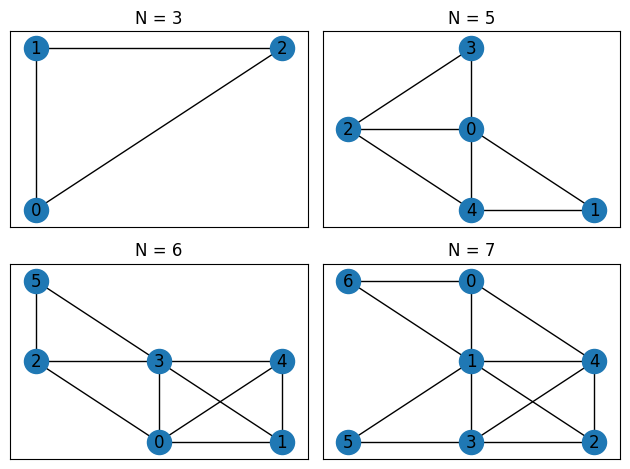

In [273]:
edgelists = [[(0, 1), (0, 2), (1, 2)], 
             [(0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (2, 3), (2, 4)],
             #[(0, 1), (0, 2), (0, 3), (0, 4), (1, 3), (1, 4), (2, 3), (2, 5), (3, 4), (3, 5)], 
             [(0, 1), (0, 2), (0, 3), (0, 4), (1, 3), (1, 4), (2, 3), (2, 5), (3, 4), (3, 5)],
             [(0, 1), (0, 4), (0, 6), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 3), (2, 4), (3, 4), (3, 5)]]


coordinate_list = [[(0, 0), (0, 1), (1, 1)],
                   [(1, 1), (2, 0), (0, 1), (1, 2), (1, 0)],
                   [(1, 0), (2, 0), (0, 1), (1, 1), (2, 1), (0, 2)],
                   [(1, 2), (1, 1), (2, 0), (1, 0), (2, 1), (0, 0), (0, 2)]]


G_set = [nx.from_edgelist(edgelist) for edgelist in edgelists]

fig, axs = plt.subplots(2, 2)
for i, ax in enumerate(fig.axes):
    pos = {n: pos for n, pos in enumerate(coordinate_list[i])}  
    nx.draw_networkx(G_set[i], pos, ax=ax)
    ax.set_title("N = {}".format(len(G_set[i].nodes())))

#fig.suptitle("Graphs of Interest")
plt.tight_layout()
plt.show()

In [307]:
import numpy as np

def calculate_distance(point1, point2):
    """Calculate Euclidean distance between two points."""
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

def check_distances(points, pairs, epsilon, d_min):
    """Check if the distance constraints are satisfied."""
    distances = {}
    
    # Calculate distances for the given pairs
    for (i, j) in pairs:
        distance = calculate_distance(points[i], points[j])
        distances[(i, j)] = distance
    
    # Check the difference constraints
    for (i, j) in pairs:
        for (k, l) in pairs:
            if (i, j) != (k, l):  # Avoid comparing the same pair
                if not (abs(distances[(i, j)] - distances[(k, l)]) < epsilon):
                    return False
    
    # Check minimum distance constraints
    for (i, j) in pairs:
        if distances[(i, j)] <= d_min:
            return False

    return True

def optimize_point_placement(pairs, epsilon=0.1, d_min=0.5):
    """Optimize the placement of points."""
    # Initialize points randomly
    points = np.random.rand(max(max(pair) for pair in pairs) + 1, 2)*2   # Random points in 2D space
    
    # Iteratively adjust points
    for iteration in range(10000):  # Max iterations
        # Check constraints
        if check_distances(points, pairs, epsilon, d_min):
            print(f"Valid placement found in iteration {iteration}: {points}")
            return points
        
        # Randomly adjust points to try to find a valid configuration
        adjustment = (np.random.rand(*points.shape) - 0.5) * 1  # Random adjustment
        points += adjustment

    print("No valid placement found after maximum iterations.")
    return points

# Example pairs based on the provided input
pairs = [(0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (2, 3), (2, 4)]

# Run the optimization
optimized_points = optimize_point_placement(pairs, epsilon=1, d_min=0.5)


Valid placement found in iteration 8: [[ 1.0708735   1.19901449]
 [ 0.43087538  0.81696944]
 [-0.29555711  0.91889749]
 [ 1.11490596  0.4447591 ]
 [ 0.57671531  0.12493187]]


In [335]:
import numpy as np
from scipy.optimize import minimize

def calculate_distance(point1, point2):
    """Calculate Euclidean distance between two points."""
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

def objective_function(points, pairs):
    """Objective function to minimize the sum of all distances for the given pairs."""
    total_distance = 0
    for (i, j) in pairs:
        total_distance += calculate_distance(points[2*i:2*i+2], points[2*j:2*j+2])
    return total_distance

def distance_constraints(points, pairs, epsilon, d_min):
    """Generate the constraints for COBYLA based on distance requirements."""
    constraints = []
    
    # Constraint on minimum distance for each pair
    for (i, j) in pairs:
        constraints.append({
            'type': 'ineq',
            'fun': lambda points, i=i, j=j: calculate_distance(points[2*i:2*i+2], points[2*j:2*j+2]) - d_min
        })
        
    # Constraint on epsilon for distance differences between pairs
    for (i, j) in pairs:
        for (k, l) in pairs:
            if (i, j) != (k, l):
                constraints.append({
                    'type': 'ineq',
                    'fun': lambda points, i=i, j=j, k=k, l=l: epsilon - abs(
                        calculate_distance(points[2*i:2*i+2], points[2*j:2*j+2]) -
                        calculate_distance(points[2*k:2*k+2], points[2*l:2*l+2])
                    )
                })

    return constraints

def optimize_point_placement_cobyla(pairs, epsilon=0.1, d_min=0.5):
    """Optimize the placement of points using COBYLA."""
    num_points = max(max(pair) for pair in pairs) + 1
    initial_points = np.random.rand(num_points * 2) * 2  # Random initial points in 2D
    
    # Define constraints
    constraints = distance_constraints(initial_points, pairs, epsilon, d_min)
    
    # Run optimization
    result = minimize(
        objective_function,
        initial_points,
        args=(pairs,),
        method='COBYLA',
        constraints=constraints
    )
    
    # Reshape optimized points to 2D array for easier interpretation
    optimized_points = result.x.reshape((num_points, 2))
    if result.success:
        print("Optimized placement found:", optimized_points)
    else:
        print("Optimization failed:", result.message)
    
    return optimized_points

# Example pairs
pairs = [(0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (2, 3), (2, 4)]

# Run the COBYLA optimization
optimized_points = optimize_point_placement_cobyla(pairs, epsilon=1, d_min=0.5)


Optimized placement found: [[1.07834894 1.5745632 ]
 [0.72270017 1.22311768]
 [1.56053407 1.44228509]
 [1.43399771 1.92600872]
 [1.2048853  1.09083957]]


In [311]:
optimized_cordinate = []
for edge in edgelists:
    optimized_cordinate.append(optimize_point_placement(edge , epsilon=0.5 , d_min=1))


Valid placement found in iteration 75: [[ 1.54487475  0.93086427]
 [ 3.23731399 -0.18068649]
 [ 3.29925168  1.80499888]]
No valid placement found after maximum iterations.
No valid placement found after maximum iterations.
No valid placement found after maximum iterations.


In [ ]:
fig, axs = plt.subplots(2, 2)
for i, ax in enumerate(fig.axes):
    pos = {n: pos for n, pos in enumerate(optimized_cordinate[i])}  
    nx.draw_networkx(G_set[i], pos, ax=ax)
    ax.set_title("N = {}".format(len(G_set[i].nodes())))

#fig.suptitle("Graphs of Interest")
plt.tight_layout()
plt.show()

# 2. Classical calculation

In [164]:
from itertools import combinations

def get_max_cut(G):
    """
    This function computes the max cut of a given graph.

    Input: Graph G

    Output: max_cut of the graph and associated partition
    """
    def two_partitions(lst):
        result = set()
        
        # Generate all possible combinations for the first subset
        for i in range(1, len(lst)):
            for part1 in combinations(lst, i):
                part1 = set(part1)
                part2 = set(lst) - part1  # The other subset is what remains
                # Add the partition to the set to avoid duplicates
                parti = frozenset([frozenset(part1), frozenset(part2)])
                result.add(parti)
        
        # Convert partitions to lists 
        return [list(map(list, parti)) for parti in result]
    
    partitions = two_partitions(range(len(G.nodes())))
    new_partitions = []

    for part in partitions:
        cut = 0
        for u in part[0]:
            for v in part[1]:
                if G.has_edge(u, v):
                    cut += 1

        # Add the partition with the cut count at the beginning
        new_partitions.append([cut] + part)

    max_cut = max(partition[0] for partition in new_partitions)
    max_cut_partitions = [partition for partition in new_partitions if partition[0] == max_cut]

    return max_cut, max_cut_partitions


In [165]:
for graph in G_set:
    print(get_max_cut(graph))

(2, [[2, [1, 2], [0]], [2, [1], [0, 2]], [2, [0, 1], [2]]])
(5, [[5, [3, 4], [0, 1, 2]], [5, [0, 3, 4], [1, 2]], [5, [1, 2, 3], [0, 4]], [5, [0, 2], [1, 3, 4]]])
(7, [[7, [1, 2, 4, 5], [0, 3]], [7, [0, 4, 5], [1, 2, 3]], [7, [1, 2, 4], [0, 3, 5]], [7, [0, 1, 5], [2, 3, 4]]])
(9, [[9, [2, 4, 5, 6], [0, 1, 3]]])


# 3. QAOA

The method consists of starting from a Hamiltonian that does not correspond to our graph but rather to a placement of the graph's points independently of each other; this is what we represent by the Hamiltonian $H_x$. Then, we construct an interaction Hamiltonian that maps the connections between the nodes of our graph, which we call the Hamiltonian $H_c$. The Hamiltonian $H_x$ has a well-known ground state. This method involves initializing the system in the ground state of the Hamiltonian $H_x$, then using the parameters $\eta$ to slowly evolve the Hamiltonian $H_{x}$ towards the Hamiltonian $H_c$. Since the evolution is slow, this ensures that the system remains in the ground state throughout the procedure, and thus, in the end, the system is in the ground state of the Hamiltonian associated with our graph $H_c$.

### The code
1. I create the function `u_x` which is the evolution operator of the Hamiltonian `hx`.
$$
H_x = \sum_{i}X_i
$$
$$
U_x = e^{-iH_{x}dt}
$$

2. I create the function `u_c` which is the evolution operator of the Hamiltonian `hc`.
$$
H_c = \sum_{i<j}J_{i,j}Z_{i}Z_{j}
$$
$$
U_c = e^{-iH_{c}dt}
$$

3. I create the function `U_init()` which creates a circuit that returns the ground state of `hx`.

4. I create the function `u_n` which applies the Suzuki-Trotter approximation of $U_{\eta}$. 
$$
U_{\eta} = \prod_{j = 1}^{\eta}exp\left(-i\left[\frac{j - 1}{\eta -1}H_{c} + \frac{\eta - j}{\eta -1}H_{x}\right]\right)
$$
With Suzuki-Trotter approximation we have:
$$
U_{\eta} \approx \prod_{j = 1}^{\eta}\left[U_{c}\left(\frac{j - 1}{m(\eta -1)}\right)U_{x}\left(\frac{\eta - j}{m(\eta -1)}\right)\right]^{m}
$$

We notice that at each iteration, as $\frac{j - 1}{m(\eta -1)}$ increases, $\frac{\eta - j}{m(\eta -1)}$ decreases, which reflects the transition from the Hamiltonian `hx` to `hc`.

5. The function `qaoa_circuit` simply initializes the circuit in the ground state of $H_{x}$ before applying `u_n`.

6. The function `ground_state_optimizer()` in this function, I use the qaoa_circuit function with the evolve method to retrieve the state vector of our circuit after the evolution of our system: $$\ket{\Phi_{\eta,m}} = U_{\eta , m}U_{init}\ket{0}$$ Then I calculate ``cost``, which is the eigenvalue of this state vector: $$C = \bra{\Phi_{\eta,m}}H_{c}\ket{\Phi_{\eta,m}}$$ then we perform optimization on C to make it as small as possible and thus obtain a good approximation of the ground state $\ket{\Phi_{\eta,m}}$. The optimization doesn't seem to work very well, probably because the increments of $\eta$ and ``m`` are integers. I could solve this problem for m by changing the way I construct the ``u_n`` circuit. I could first obtain the matrix corresponding to $$ U_{c}(\frac{j - 1}{m(\eta - 1)})U_{x}(\frac{\eta - j}{m(\eta - 1)})$$ Then apply the power m and transform the resulting matrix into an observable, and finally add it to the ``u_c`` circuit.

7. .
   
8. The function `calculate_maxcut_from_strings()` executes the final task. At this stage, I already have the bit string that corresponds to the partition of the maxcut. In fact, the "0" bits form one partition and the "1" bits form the other. For example, if I have "0101" with the order "0123", then the nodes from zero, namely {0, 2}, form one partition and {1, 3} form the other partition. It only remains to determine the number of edges that connect these partitions, which is the maxcut.

Unfortunately, I couldn't find a simple Python function to estimate the maxc for quick comparisonut.

Also, I notice a small bug at the end of execution. When I perform the following execution, I don't have any convergence. It's only after a third execution that I obtain results.keep the largest one.


In [5]:
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorSampler
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime.fake_provider import FakeMelbourneV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator

from scipy.optimize import minimize

## 3.1 Build $U_{x}$

In [6]:
def U_x(n, t):
    """
        input: n: nombre de qubit
               t: temps d'évolution
        ouput: QuantumCircuit
    """
    # Définir les matrices de Pauli et l'identité
    I = SparsePauliOp("I")
    X = SparsePauliOp("X")

    # Initialiser un opérateur total vide
    operator_total = None

    # Boucle pour créer les opérateurs et les additionner
    for i in range(n):
        A = [I] * n
        A[i] = X
        operator = A[0]
        
        for matrix in A[1:]:
            operator = operator ^ matrix
        if operator_total is None:
            operator_total = operator
        else:
            operator_total += operator

    # Construire la porte d'évolution
    evo = PauliEvolutionGate(operator_total, time=t)

    # Insérer dans un circuit
    circuit = QuantumCircuit(n)  # Le nombre de qubits doit correspondre à la longueur de A
    circuit.append(evo, range(n))

    return circuit

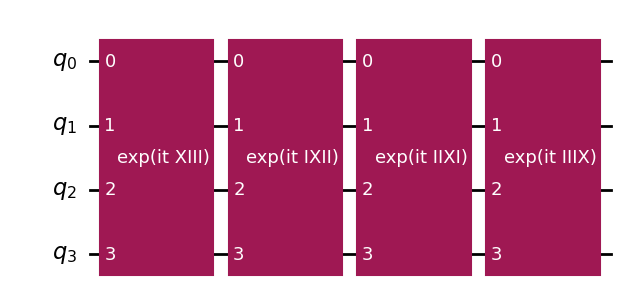

In [7]:
# Exemple d'utilisation de la fonction
n = 4
t = 0.2
circuit = U_x(n, t)
circuit.decompose().draw("mpl")

## 3.2 Build $U_c$

In [8]:
def U_c(n, J, t):
    # Définir les matrices de Pauli et l'identité
    """
    input: nombre de qubit
        branches du graphes
        temps d'évolution
    ouput: QuantumCircuit
    """
    I = SparsePauliOp("I")
    Z = SparsePauliOp("Z")

    # Initialiser un opérateur total vide
    operator_total = None

    # Boucle pour créer les opérateurs et les additionner
    for (i, j) in J:
        # Créer un vecteur de matrices I
        A = [I] * n
        # Remplacer les ième et jième éléments par Z
        A[i] = Z
        A[j] = Z
        # Initialiser l'opérateur avec la première matrice du vecteur
        operator = A[0]
        # Boucle pour effectuer les produits tensoriels
        for matrix in A[1:]:
            operator = operator ^ matrix
        # Additionner les opérateurs
        if operator_total is None:
            operator_total = operator
        else:
            operator_total += operator

    # Construire la porte d'évolution
    evo = PauliEvolutionGate(operator_total, time=t)

    # Insérer dans un circuit
    circuit = QuantumCircuit(n)  # Le nombre de qubits doit correspondre à la longueur de A
    circuit.append(evo, range(n))

    return circuit

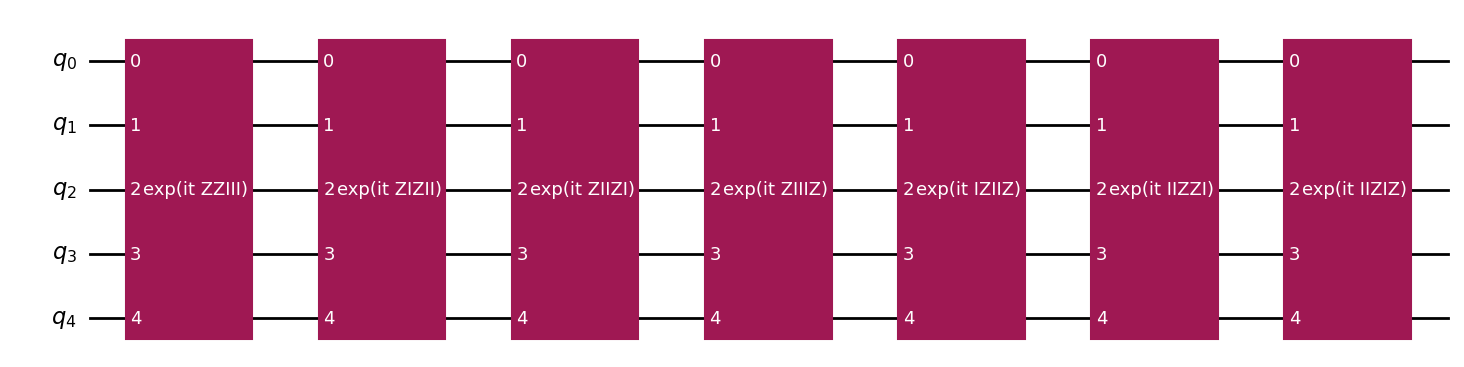

In [9]:
# Exemple d'utilisation de la fonction
n = 5
adjence_matrix = edgelists[1]
t = 0.2
circuit = U_c(n, adjence_matrix, t)
circuit.decompose().draw("mpl")

## 3.3 Build $U_{\eta}$

In [21]:
def U_n(neta: int, m: int , nombre_de_qubit, graphe):
    circuit = QuantumCircuit(nombre_de_qubit)
    
    for j in range(1, neta + 1):
        t_c = (j - 1) / (m * (neta - 1))
        t_x = (neta - j) / (m * (neta - 1))
        
        
        Uc = U_c(nombre_de_qubit, graphe, t_c)
        Ux = U_x(nombre_de_qubit, t_x)
        
        circuit_de_base = QuantumCircuit(nombre_de_qubit)
        circuit_de_base = circuit_de_base.compose(Uc)
        circuit_de_base = circuit_de_base.compose(Ux)
        
        for i in range(m - 1):
            circuit_de_base = circuit_de_base.compose(Uc)
            circuit_de_base = circuit_de_base.compose(Ux)
        
        circuit = circuit.compose(circuit_de_base)
    
    return circuit

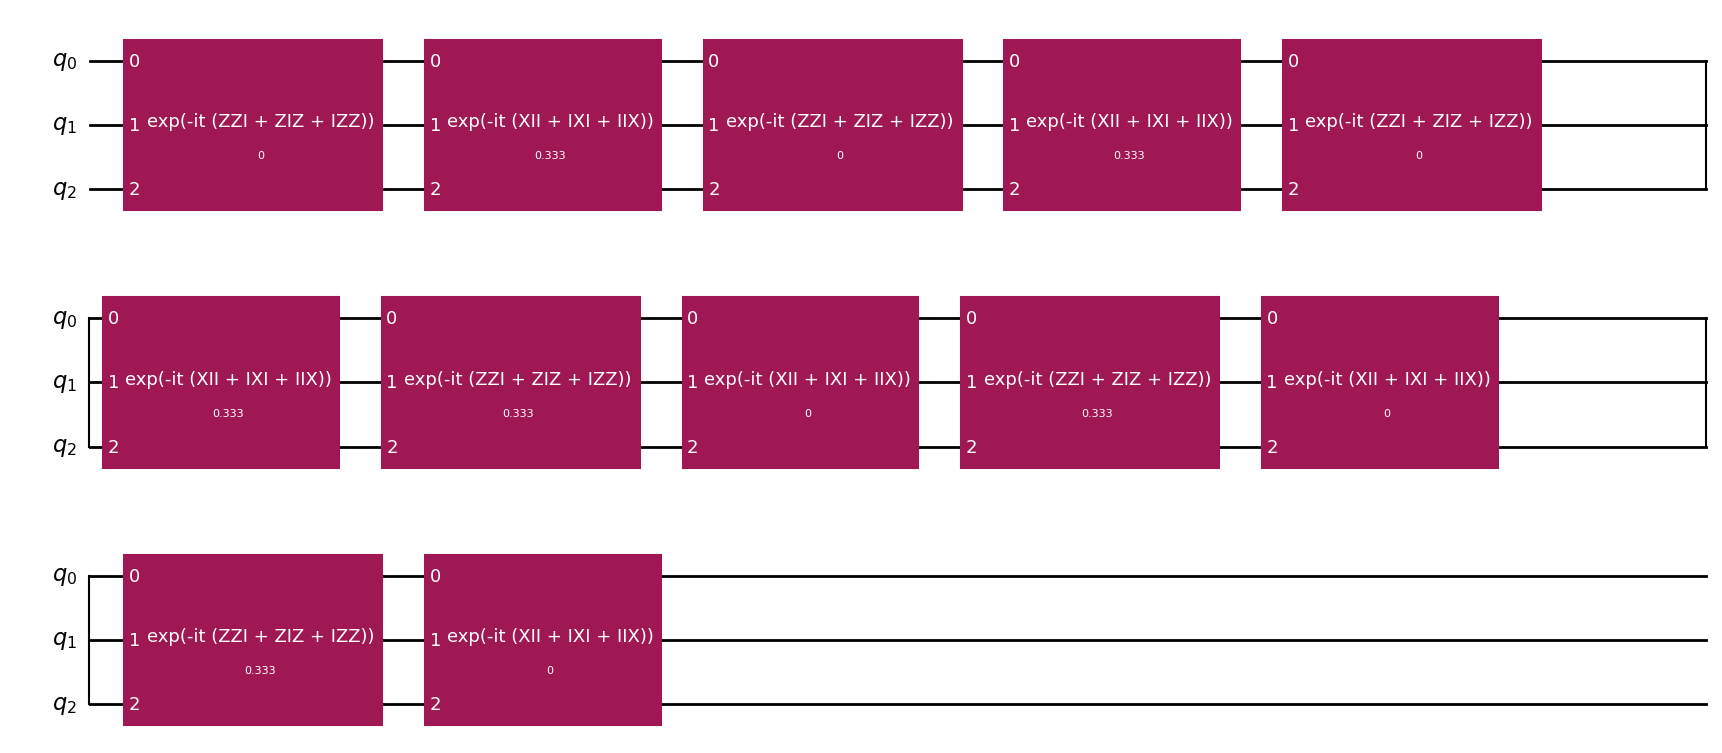

In [22]:
circuit = U_n(neta = 2 , m = 3 , nombre_de_qubit= 3 , graphe= edgelists[0])
circuit.draw("mpl")

## 3.4 Initializatiion of the circuit

In [15]:
def U_init(nombre_de_qubit):
    qc = QuantumCircuit(nombre_de_qubit)
    qc.x(range(nombre_de_qubit))
    qc.h(range(nombre_de_qubit))
    
    return qc

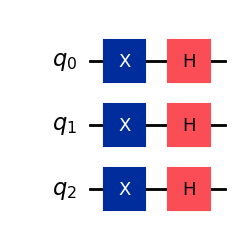

In [20]:
U_init(3).draw('mpl')

## next step 
1. reécrire u_n sans  (j - 1) / (m * (neta - 1)) et (neta - j) / (m * (neta - 1)) à l'int"rieur de la function

2. ensuite calculer l'état |phy>(gamma) =  u_n*u_unit(gamma) |0>

3. je calcul l'energie associer à |phy>(gamma) : C(gamma) = <phy|H_c|phy> que j'optimise avec un cobyla

In [41]:
# execution quantum anneling
def gate_based_quantum_annealing(graphe , neta , m):
    nombre_de_qubit = graphe.number_of_nodes()
    J = graphe.edges() #list(G.edges())
    qc = QuantumCircuit(nombre_de_qubit)
    qc = qc.compose(U_init(nombre_de_qubit))
    qc = qc.compose(U_n(neta , m , nombre_de_qubit , J))
    qc.measure_all()
    pub = (qc)
    sampler = StatevectorSampler()
    job_sampler =sampler.run([pub] , shots = 1024)

    result_sampler = job_sampler.result()
    counts_sampler = result_sampler[0].data.meas.get_counts()
    print(counts_sampler)
    plot_histogram(counts_sampler)
    #for i in 
    return counts_sampler

In [42]:
result = gate_based_quantum_annealing(G_set[3] , 50 , 15)

{'0010111': 520, '1101000': 492, '0100111': 1, '1111000': 1, '1110010': 1, '1011000': 2, '1001010': 1, '0100100': 2, '1010010': 1, '0101001': 1, '1011010': 1, '0101101': 1}


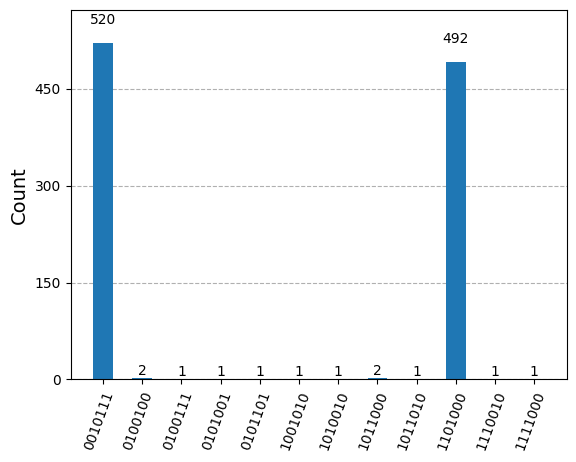

In [43]:
plot_histogram(result)

In [ ]:
(2, [[2, [1, 2], [0]], [2, [1], [0, 2]], [2, [0, 1], [2]]])
(5, [[5, [3, 4], [0, 1, 2]], [5, [0, 3, 4], [1, 2]], [5, [1, 2, 3], [0, 4]], [5, [0, 2], [1, 3, 4]]])
(7, [[7, [1, 2, 4, 5], [0, 3]], [7, [0, 4, 5], [1, 2, 3]], [7, [1, 2, 4], [0, 3, 5]], [7, [0, 1, 5], [2, 3, 4]]])
(9, [[9, [2, 4, 5, 6], [0, 1, 3]]])

result_max_cut après suppression des complémentaires : {'0010111': 520, '1101000': 492}


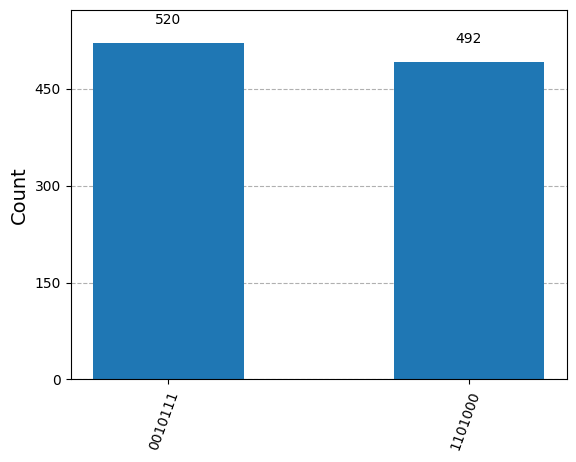

In [44]:
# Trouver la valeur maximale dans le dictionnaire
max_value = max(result.values())

# Créer un dictionnaire pour stocker les éléments qui satisfont la condition
result_max_cut = {}

# Parcourir le dictionnaire result pour ajouter les éléments à result_max_cut
for key, value in result.items():
    # Ajouter à result_max_cut si la valeur est au moins 50% de la valeur maximale
    if value >= 0.3 * max_value:
        result_max_cut[key] = value


print("result_max_cut après suppression des complémentaires :", result_max_cut)
plot_histogram(result_max_cut )


In [45]:
def U_n_qaoa(neta, m, nombre_de_qubit, graphe , gamma):
    circuit = QuantumCircuit(nombre_de_qubit)
    
    for j in range(1, neta + 1):
        Uc = U_c(nombre_de_qubit, graphe, gamma[2*j])
        Ux = U_x(nombre_de_qubit, gamma[2*j - 1])
        
        circuit_de_base = QuantumCircuit(nombre_de_qubit)
        circuit_de_base = circuit_de_base.compose(Uc)
        circuit_de_base = circuit_de_base.compose(Ux)
        
        for i in range(m - 1):
            circuit_de_base = circuit_de_base.compose(Uc)
            circuit_de_base = circuit_de_base.compose(Ux)
        
        circuit = circuit.compose(circuit_de_base)
    
    return circuit

# Example usage (assuming qubit_nbr and J are defined):
# circuit = U_n(5, 3, qubit_nbr, J)

In [46]:
def etat_phi(graphe , neta , gamma , m):
    nombre_de_qubit = graphe.number_of_nodes()
    J = graphe.edges() #list(G.edges())
    qc =  QuantumCircuit(nombre_de_qubit)
    qc = qc.compose(U_init(nombre_de_qubit))
    qc = qc.compose(U_n_qaoa(neta , m , nombre_de_qubit , J , gamma))

    return qc

In [47]:
neta = 5
m = 1
graphe = G_set[0]
gamma = [0]*(2*neta + 1)

In [50]:
def Cost(graphe, neta, gamma, m):
    I = SparsePauliOp("I")
    Z = SparsePauliOp("Z")

    # Initialiser un opérateur total vide
    h_c = None
    J = graphe.edges()
    nombre_de_qubit = graphe.number_of_nodes()
    # Boucle pour créer les opérateurs et les additionner
    for (i, j) in J:
        # Créer un vecteur de matrices I
        A = [I] * nombre_de_qubit
        # Remplacer les ième et jième éléments par Z
        A[i] = Z
        A[j] = Z
        # Initialiser l'opérateur avec la première matrice du vecteur
        operator = A[0]
        # Boucle pour effectuer les produits tensoriels
        for matrix in A[1:]:
            operator = operator ^ matrix
        # Additionner les opérateurs
        if h_c is None:
            h_c = operator
        else:
            h_c += operator

    # Step 2: Define quantum state
    circuit = etat_phi(graphe, neta, gamma, m)

    # Define a local backend
    backend = FakeMelbourneV2()

    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    isa_circuit = pm.run(circuit)

    isa_observable = h_c.apply_layout(isa_circuit.layout)

    estimator = Estimator(backend, options={"default_shots": int(1e4)})
    job = estimator.run([(isa_circuit, isa_observable)])

    # Get results for the first (and only) PUB
    pub_result = job.result()[0]
    return pub_result.data.evs

def optimize_gamma(graphe, neta, m, gamma_init):
    # Définir la fonction de coût avec seulement gamma comme variable
    def cost_function(gamma):
        return Cost(graphe, neta, gamma, m)

    # Appeler la fonction minimize pour trouver la valeur optimale de gamma
    result = minimize(cost_function, gamma_init, method='COBYLA')  # Vous pouvez changer la méthode si nécessaire
    return result


In [51]:
# Exemple d'appel de l'optimisation
graphe = G_set[2]  # Définissez votre graphe ici
neta = 10    # Définissez neta ici
m = 5      # Définissez m ici
gamma_init = [0]*(2*neta + 1)  # Initialisation de gamma

result = optimize_gamma(graphe, neta, m, gamma_init)
print(f"Valeur optimale de gamma: {result.x}")
print(f"Valeur de la fonction coût: {result.fun}")

c:\Users\isaac\anaconda3\envs\pulser_env\Lib\site-packages\qiskit_ibm_runtime\fake_provider\fake_backend.py:374: RuntimeWarning: Aer not found, using qiskit.BasicSimulator and no noise.
  warnings.warn(


KeyboardInterrupt: 

result_max_cut après suppression des complémentaires : {'100100': 60, '110001': 56, '001011': 56, '110100': 53, '011110': 32, '011010': 49, '011011': 84, '001110': 59, '011001': 53, '100110': 44, '100101': 60, '011100': 48, '100011': 49, '100001': 29}


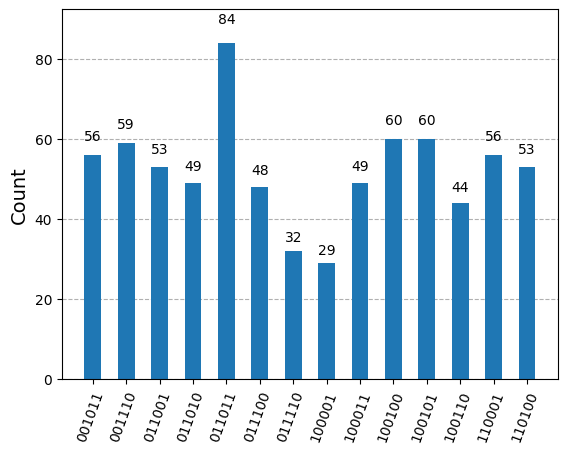

In [23]:
etat = etat_phi(graphe , neta , result.x , m)
etat.measure_all()
pub = (etat)
sampler = StatevectorSampler()
job_sampler =sampler.run([pub] , shots = 1024)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.meas.get_counts()
#print(counts_sampler)


# Trouver la valeur maximale dans le dictionnaire
max_value = max(counts_sampler.values())

# Créer un dictionnaire pour stocker les éléments qui satisfont la condition
result_max_cut = {}

# Parcourir le dictionnaire result pour ajouter les éléments à result_max_cut
for key, value in counts_sampler.items():  # Assuming counts_sampler is the correct dictionary here
    # Ajouter à result_max_cut si la valeur est au moins 50% de la valeur maximale
    if value >= 0.3 * max_value:
        result_max_cut[key] = value

print("result_max_cut après suppression des complémentaires :", result_max_cut)
plot_histogram(result_max_cut)

# 4. Quantum annealer with Pulser

In [1]:
import pulser
from pulser import DigitalAnalogDevice, Register, Pulse, Sequence
from pulser_simulation import QutipEmulator
from pulser.waveforms import InterpolatedWaveform

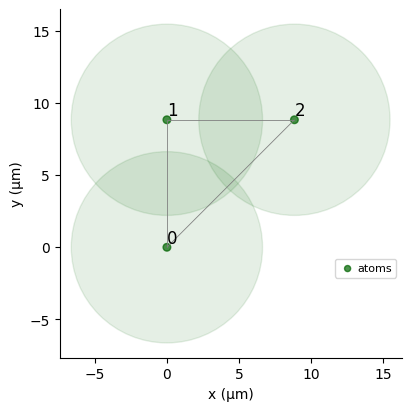

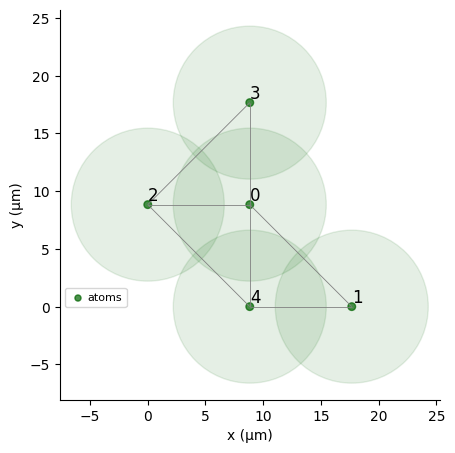

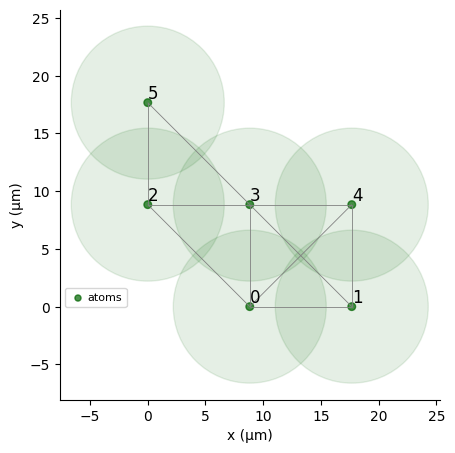

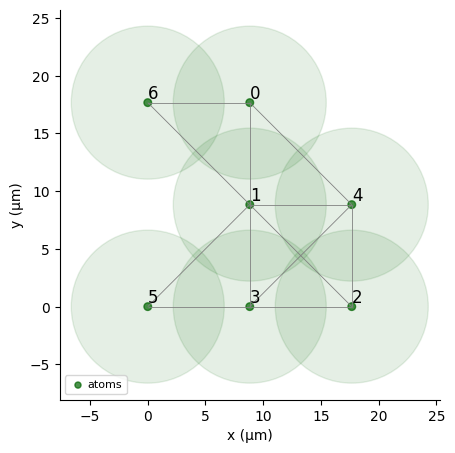

In [211]:
scale = DigitalAnalogDevice.rydberg_blockade_radius(1.0) / 1.5
n = len(coordinate_list)  # Nombre de configurations d'atomes

# Créer une liste pour stocker chaque figure
figures = []
Register_list = []

# Boucle pour créer un Register et stocker chaque figure dessinée dans la liste 'figures'
for i in range(n):
    coords_scaled = [(x * scale, y * scale) for (x, y) in coordinate_list[i]]
    qubits = dict(enumerate(coords_scaled))
    reg = Register(qubits)
    Register_list.append(reg)
    # Créer une figure temporaire
    #fig = plt.figure()
    reg.draw(
        blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1.0),
        draw_graph=True,
        draw_half_radius=True,
    )
    
    #figures.append(fig)  # Stocker la figure

In [213]:
# We choose a median value between the min and the max
Omega = 4
delta_0 = -5  # just has to be negative
delta_f = -delta_0  # just has to be positive
T = 10000  # time in ns, we choose a time long enough to ensure the propagation of information in the system

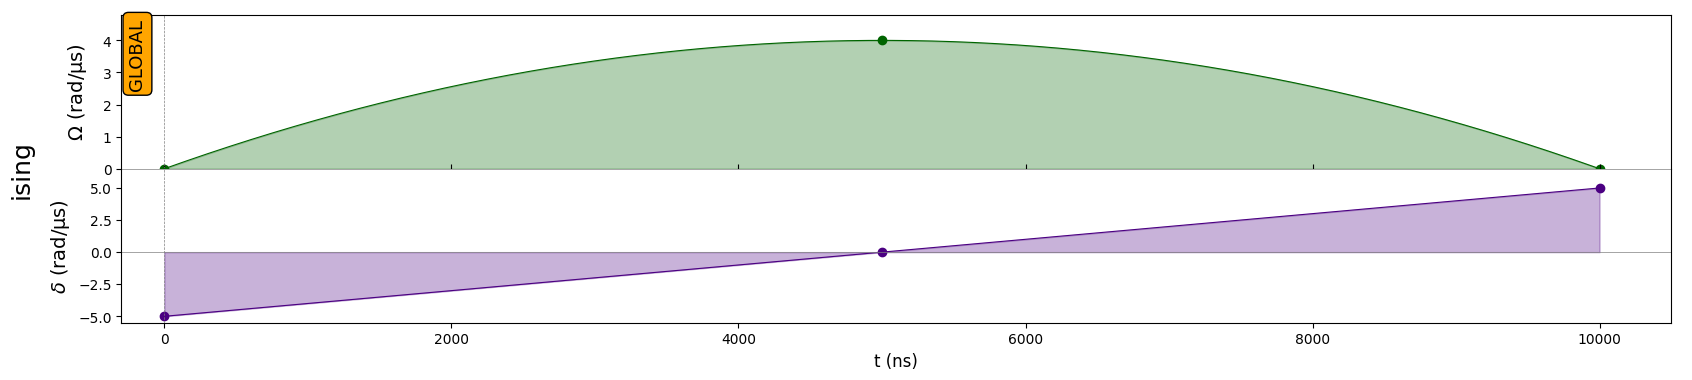

In [214]:
#Create Pulse sequence, using default setting found
adiabatic_pulse = Pulse(
    InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
    InterpolatedWaveform(T, [delta_0, 0, delta_f]),
    0,
)
seq = Sequence(Register_list[3], DigitalAnalogDevice)
seq.declare_channel("ising", "rydberg_global")
seq.add(adiabatic_pulse, "ising")
seq.draw()

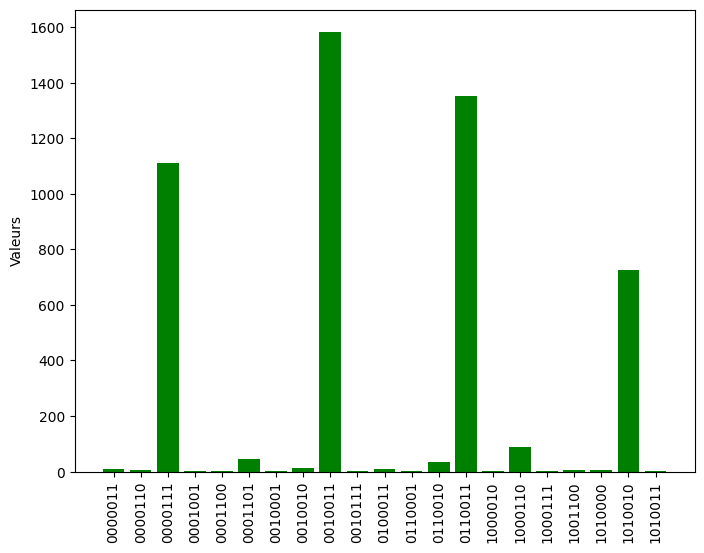

In [215]:
simul = QutipEmulator.from_sequence(seq)
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state(N_samples= 5000)

# Création de l'histogramme
plt.figure(figsize=(8, 6))
plt.bar(list(count_dict.keys()), list(count_dict.values()), color='green')
plt.xticks(rotation = "vertical")
plt.ylabel('Valeurs')
plt.show()

In [ ]:
[[2, [1, 2], [0]], [2, [1], [0, 2]], [2, [0, 1], [2]]]
[[5, [3, 4], [0, 1, 2]], [5, [0, 3, 4], [1, 2]], [5, [1, 2, 3], [0, 4]], [5, [0, 2], [1, 3, 4]]]
[[7, [1, 2, 4, 5], [0, 3]], [7, [0, 4, 5], [1, 2, 3]], [7, [1, 2, 4], [0, 3, 5]], [7, [0, 1, 5], [2, 3, 4]]]
[[9, [2, 4, 5, 6], [0, 1, 3]]]

In [ ]:
afficher toute les soluttion et marquer parmi les resultats ceux qui ont été proposé par la méthode classique
ensuite convertir la serie de bit en une partision de de graphe claire

# Conclusion